# Профессиональный ML-анализ восстановления после ИМ

- Senior-структура пайплайна
- Подробная документация на русском
- Визуализация почти после каждого шага

In [1]:
# !pip install pandas numpy scikit-learn imbalanced-learn matplotlib seaborn xgboost shap joblib scipy openpyxl

from __future__ import annotations
import json, re, warnings
from dataclasses import dataclass, asdict
from datetime import datetime
from pathlib import Path
from typing import Any, Optional

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.base import BaseEstimator, clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, f1_score, recall_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve, auc, make_scorer)
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

try:
    from xgboost import XGBClassifier
except Exception:
    XGBClassifier = None

try:
    import shap
except Exception:
    shap = None

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

CLASS_MAPPING = {0: 'Смерть', 1: 'Не восстановился', 2: 'Восстановился'}
print('Импорты готовы. XGB:', XGBClassifier is not None, 'SHAP:', shap is not None)

Импорты готовы. XGB: False SHAP: True


## Конфиг эксперимента

In [2]:
@dataclass(slots=True)
class Config:
    input_path: Path = Path('/Users/android/Downloads/Для факт ан 25.01.26.xlsx')
    output_root: Path = Path('/Users/android/PyCharmMiscProject')
    target_column: str = 'Unnamed: 31'
    leakage_columns: tuple[str, ...] = ('ФВ 1 год', 'ХСН1 год - 1', 'реаб1')
    id_columns: tuple[str, ...] = ('ФИО пациента',)
    numeric_object_columns: tuple[str, ...] = ('ЛПНП',)
    force_categorical_columns: tuple[str, ...] = ('Тип ОКС',)
    random_state: int = 42
    test_size: float = 0.2
    high_missing_threshold: float = 0.70
    categorical_unique_threshold: int = 10
    model_set: tuple[str, ...] = ('rf', 'xgb')
    n_iter_rf: int = 40
    n_iter_xgb: int = 25
    max_outer_splits: int = 3
    max_inner_splits: int = 3
    smote_k_neighbors: int = 2
    shap_sample_size: int = 200

cfg = Config()
run_ts = datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = cfg.output_root / f'RESULT_ANALYSIS_NOTEBOOK_{run_ts}'
fig_dir = output_dir / 'figures'
table_dir = output_dir / 'tables'
artifact_dir = output_dir / 'artifacts'
for p in [output_dir, fig_dir, table_dir, artifact_dir]:
    p.mkdir(parents=True, exist_ok=True)
print('Output:', output_dir)

Output: /Users/android/PyCharmMiscProject/RESULT_ANALYSIS_NOTEBOOK_20260213_203406


## Загрузка данных и первичный аудит

Shape: (78, 32)


,ФИО пациента,Возраст на момент регистрации (полных лет),Пол ж-1 м 0,Работает 1 пенсионер 0 инвалид 3,ИМ или ЧКВ/АКШ или ОНМК анамн 1,Стен анамн1,ХСН в анамнезе 1,АГ анамн 1,ФП-1 до инфаркта,Курение 1,...,"стен, нестаб стен, ФП 1",ХСН1 год - 1,proBNP сразу,АД контр- 0 неконтроль1 гипотония2,реаб1,ИМТ,ЛПНП,ФВ до,ФВ 1 год,Unnamed: 31
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Егоров Алексей Анатольевич,47.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,NaN,0.0,0.0,29.3,2.3,45.0,50.0,восст
2,Парамонов Сергей Федорович,70.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,NaN,2.0,1.0,23.0,2.7,45.0,59.0,восст
3,Антонов Евгений Александрович,76.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,NaN,0.0,1.0,27.0,1.4,52.0,62.0,не восст
4,Теплов Сергей Юрьевич,56.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,NaN,0.0,1.0,34.0,5.6,49.0,NaN,восст


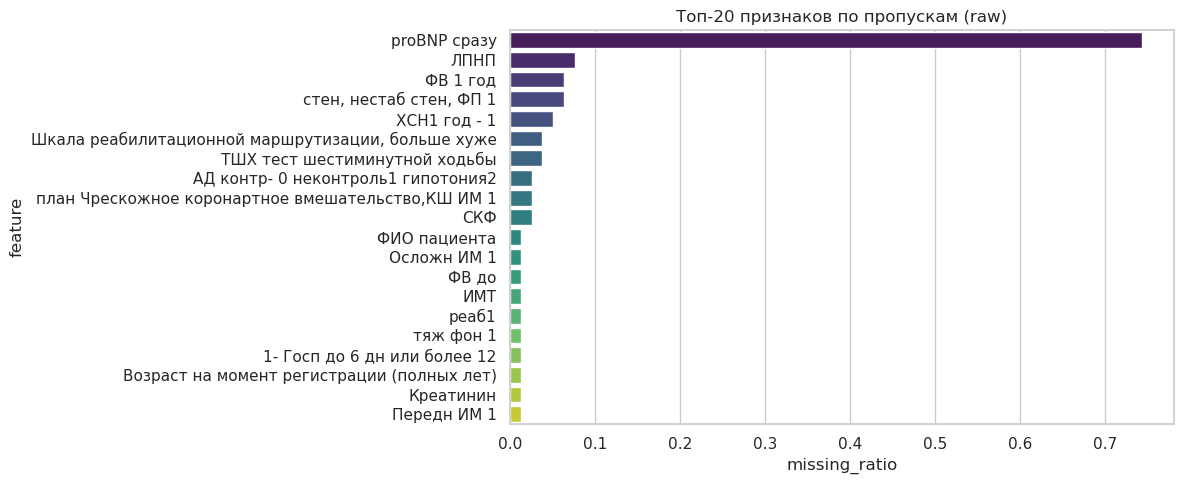

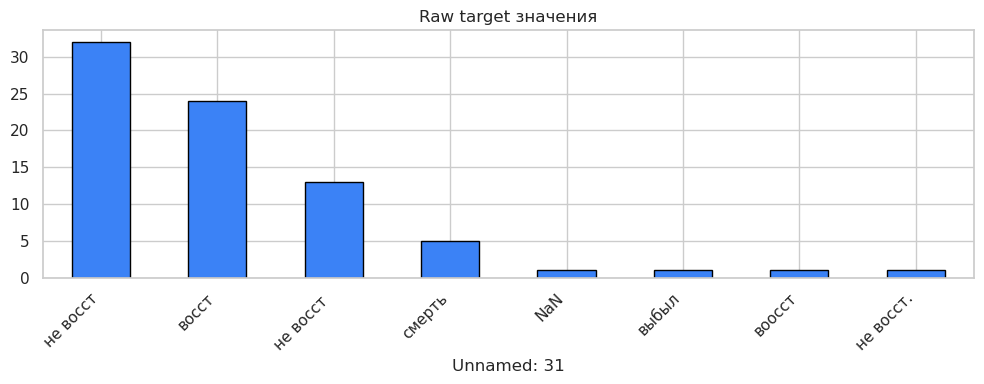

In [3]:
df_raw = pd.read_excel(cfg.input_path)
assert cfg.target_column in df_raw.columns, 'Target column не найден'
print('Shape:', df_raw.shape)
display(df_raw.head())

missing_ratio = df_raw.isna().mean().sort_values(ascending=False)
missing_df = missing_ratio.reset_index()
missing_df.columns = ['feature','missing_ratio']

plt.figure(figsize=(12,5))
sns.barplot(data=missing_df.head(20), x='missing_ratio', y='feature', palette='viridis')
plt.title('Топ-20 признаков по пропускам (raw)')
plt.tight_layout()
plt.show()

raw_target_counts = df_raw[cfg.target_column].astype('string').fillna('NaN').value_counts()
plt.figure(figsize=(10,4))
raw_target_counts.plot(kind='bar', color='#3b82f6', edgecolor='black')
plt.title('Raw target значения')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Парсинг target и аудит правил

In [4]:
def normalize_target_text(value: object) -> str:
    if pd.isna(value):
        return ''
    t = str(value).strip().lower()
    t = t.replace('ё','е')
    t = re.sub(r'\s+', ' ', t)
    t = t.replace('воосст', 'восст').replace('не восст.', 'не восст')
    return t

def parse_target_text(value: object) -> Optional[int]:
    t = normalize_target_text(value)
    if not t:
        return None
    if 'смерт' in t:
        return 0
    if 'не восст' in t:
        return 1
    if 'восст' in t and 'не восст' not in t:
        return 2
    return None

df = df_raw.copy()
df['target_normalized'] = df[cfg.target_column].map(normalize_target_text)
df['Target'] = df[cfg.target_column].map(parse_target_text)

audit_df = (df[[cfg.target_column,'target_normalized','Target']]
            .rename(columns={cfg.target_column:'raw_target'})
            .groupby(['raw_target','target_normalized','Target'], dropna=False)
            .size().reset_index(name='count').sort_values('count', ascending=False))
display(audit_df.head(20))
audit_df.to_csv(table_dir / 'target_parsing_audit.csv', index=False, encoding='utf-8-sig')

supervised_df = df[df['Target'].notna()].copy()
supervised_df['Target'] = supervised_df['Target'].astype(int)

class_counts = supervised_df['Target'].value_counts().sort_index()
plt.figure(figsize=(7,4))
plt.bar([CLASS_MAPPING[i] for i in class_counts.index], class_counts.values,
        color=['#ef4444','#f59e0b','#22c55e'], edgecolor='black')
plt.title('Классы после парсинга target')
for i,v in enumerate(class_counts.values):
    plt.text(i, v+0.2, str(v), ha='center')
plt.tight_layout()
plt.show()

,raw_target,target_normalized,Target,count
3,не восст,не восст,1.0,32
1,восст,восст,2.0,24
4,не восст,не восст,1.0,13
6,смерть,смерть,0.0,5
0,воосст,восст,2.0,1
2,выбыл,выбыл,NaN,1
5,не восст.,не восст,1.0,1
7,NaN,,NaN,1


OSError: Cannot save file into a non-existent directory: '/Users/android/PyCharmMiscProject/RESULT_ANALYSIS_NOTEBOOK_20260213_203406/tables'

## Anti-leakage preprocessing: удаление признаков из будущего и подготовка X/y

In [ ]:
model_df = supervised_df.copy()
dropped_cols=[]
for c in cfg.leakage_columns:
    if c in model_df.columns:
        model_df = model_df.drop(columns=[c]); dropped_cols.append(c)
for c in cfg.id_columns:
    if c in model_df.columns:
        model_df = model_df.drop(columns=[c]); dropped_cols.append(c)
if cfg.target_column in model_df.columns:
    model_df = model_df.drop(columns=[cfg.target_column]); dropped_cols.append(cfg.target_column)

for c in cfg.numeric_object_columns:
    if c in model_df.columns:
        model_df[c] = pd.to_numeric(model_df[c].astype('string').str.replace(',', '.', regex=False).str.strip(), errors='coerce')

X = model_df.drop(columns=['Target']).copy()
y = model_df['Target'].copy()

missing_tbl = pd.DataFrame({'feature':X.columns,'missing_count':X.isna().sum().values,'missing_ratio':X.isna().mean().values}).sort_values('missing_ratio', ascending=False)
high_missing = missing_tbl.loc[missing_tbl['missing_ratio']>cfg.high_missing_threshold, 'feature'].tolist()
if high_missing:
    X = X.drop(columns=high_missing)

missing_tbl = pd.DataFrame({'feature':X.columns,'missing_count':X.isna().sum().values,'missing_ratio':X.isna().mean().values}).sort_values('missing_ratio', ascending=False)
display(missing_tbl.head(20))
missing_tbl.to_csv(table_dir / 'missingness_table.csv', index=False, encoding='utf-8-sig')

plt.figure(figsize=(12,5))
sns.barplot(data=missing_tbl.head(20), x='missing_ratio', y='feature', palette='magma')
plt.title('Пропуски после фильтра high-missing')
plt.tight_layout()
plt.show()

num_candidates = X.select_dtypes(include=[np.number]).columns.tolist()
cat_candidates = X.select_dtypes(exclude=[np.number]).columns.tolist()
num_features=[]
cat_features=list(cat_candidates)
for c in num_candidates:
    if c in cfg.force_categorical_columns:
        cat_features.append(c)
    elif X[c].nunique(dropna=True) <= cfg.categorical_unique_threshold:
        cat_features.append(c)
    else:
        num_features.append(c)
num_features=sorted(set(num_features)); cat_features=sorted(set(cat_features))
print('Dropped:', dropped_cols + high_missing)
print('Num features:', len(num_features), 'Cat features:', len(cat_features))

## Split-first: train/test до SMOTE

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=cfg.test_size, random_state=cfg.random_state, stratify=y
)
print('Train:', X_train.shape, 'Test:', X_test.shape)

tr = y_train.value_counts().sort_index()
te = y_test.value_counts().sort_index()
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].bar([CLASS_MAPPING[i] for i in tr.index], tr.values, color=['#ef4444','#f59e0b','#22c55e'], edgecolor='black')
axes[0].set_title('Train balance')
axes[1].bar([CLASS_MAPPING[i] for i in te.index], te.values, color=['#ef4444','#f59e0b','#22c55e'], edgecolor='black')
axes[1].set_title('Test balance')
for ax in axes: ax.tick_params(axis='x', rotation=15)
plt.tight_layout(); plt.show()

## Построение preprocessor и AdaptiveSMOTE

In [ ]:
class AdaptiveSMOTE(BaseEstimator):
    def __init__(self, k_neighbors=2, random_state=42, sampling_strategy='auto'):
        self.k_neighbors = k_neighbors
        self.random_state = random_state
        self.sampling_strategy = sampling_strategy
    def fit(self, X, y):
        return self
    def fit_resample(self, X, y):
        y_ser = pd.Series(y)
        min_class = int(y_ser.value_counts().min())
        if min_class <= 1:
            self.resolved_k_ = 0
            self.skipped_ = True
            return X, y
        k = min(self.k_neighbors, min_class - 1)
        self.resolved_k_ = int(k)
        self.skipped_ = False
        sm = SMOTE(k_neighbors=self.resolved_k_, random_state=self.random_state, sampling_strategy=self.sampling_strategy)
        return sm.fit_resample(X, y)

num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),('scaler', StandardScaler())])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
preprocessor = ColumnTransformer([('num', num_pipe, num_features), ('cat', cat_pipe, cat_features)], sparse_threshold=0, remainder='drop')
print('Preprocessor готов')

## Обучение моделей (nested CV) и сравнение

In [ ]:
def recall_class_0(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=[0], average='macro', zero_division=0)

def infer_cv_splits(y_series, max_splits):
    m = int(pd.Series(y_series).value_counts().min())
    if m < 2:
        raise ValueError('Недостаточно объектов для Stratified CV')
    return max(2, min(max_splits, m))

def make_model(name, seed):
    if name == 'rf':
        return RandomForestClassifier(random_state=seed, n_jobs=-1)
    if name == 'xgb':
        if XGBClassifier is None:
            raise ImportError('xgboost недоступен')
        return XGBClassifier(random_state=seed, n_jobs=-1, objective='multi:softprob', eval_metric='mlogloss', num_class=3)
    raise ValueError(name)

def get_param_space(name):
    if name == 'rf':
        return {'model__n_estimators':[120,200,300,500], 'model__max_depth':[None,4,6,10,14], 'model__min_samples_split':[2,4,6,8], 'model__min_samples_leaf':[1,2,3], 'model__max_features':['sqrt','log2',None], 'model__class_weight':['balanced','balanced_subsample',None]}
    if name == 'xgb':
        return {'model__n_estimators':[80,120,200,300], 'model__max_depth':[2,3,4,5], 'model__learning_rate':[0.01,0.03,0.05,0.1], 'model__subsample':[0.8,0.9,1.0], 'model__colsample_bytree':[0.7,0.9,1.0], 'model__reg_lambda':[1.0,2.0,5.0], 'model__min_child_weight':[1,3,5], 'model__gamma':[0.0,0.1,0.2]}
    raise ValueError(name)

def make_pipeline(name):
    return ImbPipeline([('preprocess', clone(preprocessor)),('smote', AdaptiveSMOTE(k_neighbors=cfg.smote_k_neighbors, random_state=cfg.random_state)),('model', make_model(name, cfg.random_state))])

def run_nested(name):
    n_iter = cfg.n_iter_rf if name=='rf' else cfg.n_iter_xgb
    outer = StratifiedKFold(n_splits=infer_cv_splits(y_train, cfg.max_outer_splits), shuffle=True, random_state=cfg.random_state)
    scoring = {'f1_macro': make_scorer(f1_score, average='macro', zero_division=0), 'recall_class_0': make_scorer(recall_class_0)}
    rows=[]
    for fold,(tr_idx,val_idx) in enumerate(outer.split(X_train,y_train), start=1):
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        inner = StratifiedKFold(n_splits=infer_cv_splits(y_tr, cfg.max_inner_splits), shuffle=True, random_state=cfg.random_state)
        rs = RandomizedSearchCV(make_pipeline(name), get_param_space(name), n_iter=n_iter, scoring=scoring, refit='f1_macro', cv=inner, n_jobs=-1, random_state=cfg.random_state, return_train_score=False)
        rs.fit(X_tr, y_tr)
        pred = rs.best_estimator_.predict(X_val)
        rows.append({'model':name,'fold':fold,'inner_best_f1_macro':float(rs.best_score_), 'outer_accuracy':float(accuracy_score(y_val,pred)), 'outer_f1_macro':float(f1_score(y_val,pred,average='macro',zero_division=0)), 'outer_f1_weighted':float(f1_score(y_val,pred,average='weighted',zero_division=0)), 'outer_recall_class_0':float(recall_class_0(y_val,pred)), 'smote_resolved_k':getattr(rs.best_estimator_.named_steps['smote'],'resolved_k_',np.nan), 'best_params':str(rs.best_params_)})
    outer_df = pd.DataFrame(rows)
    summary = {'outer_accuracy_mean':float(outer_df['outer_accuracy'].mean()), 'outer_f1_macro_mean':float(outer_df['outer_f1_macro'].mean()), 'outer_f1_weighted_mean':float(outer_df['outer_f1_weighted'].mean()), 'outer_recall_class_0_mean':float(outer_df['outer_recall_class_0'].mean())}
    full_inner = StratifiedKFold(n_splits=infer_cv_splits(y_train, cfg.max_inner_splits), shuffle=True, random_state=cfg.random_state)
    final_rs = RandomizedSearchCV(make_pipeline(name), get_param_space(name), n_iter=n_iter, scoring=scoring, refit='f1_macro', cv=full_inner, n_jobs=-1, random_state=cfg.random_state, return_train_score=True)
    final_rs.fit(X_train, y_train)
    return {'name':name,'outer_df':outer_df,'summary':summary,'cv_results':pd.DataFrame(final_rs.cv_results_),'best_params':final_rs.best_params_,'best_estimator':final_rs.best_estimator_}

results=[]
for m in cfg.model_set:
    try:
        r=run_nested(m)
        results.append(r)
        print('Готово:', m)
    except ImportError as e:
        print('Пропуск', m, e)

comparison_df = pd.DataFrame([{'model':r['name'], **r['summary']} for r in results]).sort_values(['outer_f1_macro_mean','outer_recall_class_0_mean'], ascending=False)
display(comparison_df)
comparison_df.to_csv(table_dir / 'model_comparison.csv', index=False, encoding='utf-8-sig')

for r in results:
    r['outer_df'].to_csv(table_dir / f"outer_cv_{r['name']}.csv", index=False, encoding='utf-8-sig')
    r['cv_results'].to_csv(table_dir / f"cv_results_{r['name']}.csv", index=False, encoding='utf-8-sig')

plt.figure(figsize=(8,4))
plot_df = comparison_df.melt(id_vars='model', value_vars=['outer_f1_macro_mean','outer_recall_class_0_mean'], var_name='metric', value_name='value')
sns.barplot(data=plot_df, x='model', y='value', hue='metric', palette='Set2')
plt.title('Сравнение моделей по outer CV')
plt.tight_layout(); plt.show()

## Holdout-оценка лучшей модели + визуализация ошибок

In [ ]:
best_result = sorted(results, key=lambda r:(r['summary']['outer_f1_macro_mean'], r['summary']['outer_recall_class_0_mean']), reverse=True)[0]
best_model = best_result['best_estimator']
y_pred = best_model.predict(X_test)

holdout_metrics = {'accuracy':float(accuracy_score(y_test,y_pred)), 'f1_macro':float(f1_score(y_test,y_pred,average='macro',zero_division=0)), 'f1_weighted':float(f1_score(y_test,y_pred,average='weighted',zero_division=0)), 'recall_class_0':float(recall_class_0(y_test,y_pred))}
if hasattr(best_model,'predict_proba'):
    try:
        yp = best_model.predict_proba(X_test)
        holdout_metrics['roc_auc_ovr_macro'] = float(roc_auc_score(y_test, yp, multi_class='ovr', average='macro'))
    except Exception:
        holdout_metrics['roc_auc_ovr_macro'] = np.nan

print('Лучшая модель:', best_result['name'])
display(pd.DataFrame([holdout_metrics]))

rep_text = classification_report(y_test, y_pred, digits=4, zero_division=0)
rep_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True, zero_division=0)).T
print(rep_text)
display(rep_df)
rep_df.to_csv(table_dir / 'classification_report_holdout.csv', encoding='utf-8-sig')

cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
pd.DataFrame(cm, columns=['pred_0','pred_1','pred_2']).to_csv(table_dir / 'confusion_matrix_holdout.csv', index=False, encoding='utf-8-sig')

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[CLASS_MAPPING[i] for i in [0,1,2]], yticklabels=[CLASS_MAPPING[i] for i in [0,1,2]])
plt.title('Confusion Matrix (Holdout)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout(); plt.show()

if hasattr(best_model,'predict_proba'):
    yb = label_binarize(y_test, classes=[0,1,2])
    yp = best_model.predict_proba(X_test)
    plt.figure(figsize=(7,6))
    colors=['#ef4444','#f59e0b','#22c55e']
    for i,c in enumerate(colors):
        fpr,tpr,_=roc_curve(yb[:,i], yp[:,i])
        roc_auc=auc(fpr,tpr)
        plt.plot(fpr,tpr,color=c,lw=2,label=f"{CLASS_MAPPING[i]} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],'k--',lw=1)
    plt.title('ROC OvR (Holdout)')
    plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.legend(loc='lower right')
    plt.tight_layout(); plt.show()

## Feature Importance, SHAP и Radar-профили

In [ ]:
feature_importance_df = pd.DataFrame(columns=['feature','importance'])
model_core = best_model.named_steps['model']
prep_core = best_model.named_steps['preprocess']
if hasattr(model_core,'feature_importances_'):
    feature_importance_df = pd.DataFrame({'feature':prep_core.get_feature_names_out(),'importance':model_core.feature_importances_}).sort_values('importance', ascending=False)
feature_importance_df.to_csv(table_dir / 'feature_importance.csv', index=False, encoding='utf-8-sig')
display(feature_importance_df.head(20))

if not feature_importance_df.empty:
    top=feature_importance_df.head(20)
    plt.figure(figsize=(12,8))
    plt.barh(top['feature'][::-1], top['importance'][::-1], color='#10b981', edgecolor='black')
    plt.title('Top-20 Feature Importance')
    plt.tight_layout(); plt.show()

shap_status={'available': shap is not None}
if shap is not None and hasattr(model_core,'feature_importances_'):
    try:
        Xt = np.asarray(prep_core.transform(X_test))
        names = prep_core.get_feature_names_out()
        n = min(cfg.shap_sample_size, len(Xt))
        Xs = Xt[:n]
        Xs_df = pd.DataFrame(Xs, columns=names)
        explainer = shap.TreeExplainer(model_core)
        sv = explainer.shap_values(Xs)
        if isinstance(sv,list):
            c0 = sv[0]
        else:
            arr=np.asarray(sv); c0 = arr[:,:,0] if arr.ndim==3 else arr
        plt.figure(figsize=(11,7))
        shap.summary_plot(c0, Xs_df, show=False, max_display=20)
        plt.title('SHAP Beeswarm (Class 0)')
        plt.tight_layout(); plt.show()
        shap_status['beeswarm']='ok'

        ci=[i for i,nm in enumerate(names) if 'креатинин' in str(nm).lower()]
        if ci:
            plt.figure(figsize=(8,6))
            shap.dependence_plot(ci[0], c0, Xs_df, interaction_index=None, show=False)
            plt.title('SHAP dependence: Креатинин (Class 0)')
            plt.tight_layout(); plt.show()
            shap_status['creatinine_dependence']='ok'
    except Exception as e:
        shap_status['error']=str(e)
print('SHAP status:', shap_status)

cand=['Возраст на момент регистрации (полных лет)','Креатинин','СКФ','ТШХ тест шестиминутной ходьбы','ИМТ','ФВ до','ЛПНП']
avail=[c for c in cand if c in model_df.columns]
if len(avail)>=3:
    prof=[]
    for cls in [0,1,2]:
        sub=model_df[model_df['Target']==cls]
        prof.append([pd.to_numeric(sub[c],errors='coerce').mean() for c in avail])
    prof=np.array(prof,dtype=float)
    prof_norm=MinMaxScaler().fit_transform(prof.T).T
    from math import pi
    ang=[n/float(len(avail))*2*pi for n in range(len(avail))]; ang+=ang[:1]
    plt.figure(figsize=(9,9))
    ax=plt.subplot(111, polar=True)
    cols=['#ef4444','#f59e0b','#22c55e']
    for i in range(3):
        vals=prof_norm[i].tolist()+[prof_norm[i][0]]
        ax.plot(ang, vals, color=cols[i], linewidth=2.5, label=CLASS_MAPPING[i])
        ax.fill(ang, vals, color=cols[i], alpha=0.12)
    ax.set_xticks(ang[:-1])
    ax.set_xticklabels([c[:24]+('...' if len(c)>24 else '') for c in avail], fontsize=9)
    ax.set_ylim(0,1)
    ax.set_title('Radar-профили классов', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.28,1.1))
    plt.tight_layout(); plt.show()

## Сохранение графиков/артефактов/отчета

In [ ]:
joblib.dump(best_model, artifact_dir / 'final_model.pkl')
joblib.dump(best_model.named_steps['preprocess'], artifact_dir / 'preprocess_pipeline.pkl')

# обязательные сохранения
class_balance_tbl = y.value_counts().sort_index().rename_axis('class').reset_index(name='count')
class_balance_tbl['ratio'] = class_balance_tbl['count']/class_balance_tbl['count'].sum()
class_balance_tbl.to_csv(table_dir / 'class_balance_before_split.csv', index=False, encoding='utf-8-sig')

plt.figure(figsize=(7,4))
plt.bar([CLASS_MAPPING[i] for i in class_balance_tbl['class']], class_balance_tbl['count'], color=['#ef4444','#f59e0b','#22c55e'], edgecolor='black')
plt.title('Class balance before split'); plt.tight_layout(); plt.savefig(fig_dir / 'class_balance_raw.png', dpi=300); plt.close()

# before/after smote
pre = best_model.named_steps['preprocess']
sm = clone(best_model.named_steps['smote'])
Xtr_t = pre.transform(X_train)
_, y_after = sm.fit_resample(Xtr_t, y_train)
be = y_train.value_counts().sort_index(); af = pd.Series(y_after).value_counts().sort_index()
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].bar(be.index.astype(str), be.values, color='#94a3b8', edgecolor='black'); ax[0].set_title('Before SMOTE')
ax[1].bar(af.index.astype(str), af.values, color='#3b82f6', edgecolor='black'); ax[1].set_title(f"After SMOTE (k={getattr(sm,'resolved_k_', 'NA')})")
for a in ax: a.set_xlabel('Class'); a.set_ylabel('Count')
plt.tight_layout(); plt.savefig(fig_dir / 'class_balance_before_after_smote_train_only.png', dpi=300); plt.close()

# confusion save
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[CLASS_MAPPING[i] for i in [0,1,2]], yticklabels=[CLASS_MAPPING[i] for i in [0,1,2]])
plt.title('Confusion Matrix (Holdout)')
plt.tight_layout(); plt.savefig(fig_dir / 'confusion_matrix.png', dpi=300); plt.close()

# feature importance save
if not feature_importance_df.empty:
    top=feature_importance_df.head(20)
    plt.figure(figsize=(12,8))
    plt.barh(top['feature'][::-1], top['importance'][::-1], color='#10b981', edgecolor='black')
    plt.title('Top-20 Feature Importance')
    plt.tight_layout(); plt.savefig(fig_dir / 'feature_importance.png', dpi=300); plt.close()

# shap saves (best-effort)
if shap is not None and hasattr(model_core,'feature_importances_'):
    try:
        Xt = np.asarray(prep_core.transform(X_test))
        names = prep_core.get_feature_names_out()
        n = min(cfg.shap_sample_size, len(Xt))
        Xs = Xt[:n]
        Xs_df = pd.DataFrame(Xs, columns=names)
        explainer = shap.TreeExplainer(model_core)
        sv = explainer.shap_values(Xs)
        if isinstance(sv,list): c0=sv[0]
        else:
            arr=np.asarray(sv); c0 = arr[:,:,0] if arr.ndim==3 else arr
        plt.figure(figsize=(11,7)); shap.summary_plot(c0, Xs_df, show=False, max_display=20); plt.tight_layout(); plt.savefig(fig_dir / 'shap_beeswarm.png', dpi=300, bbox_inches='tight'); plt.close()
        ci=[i for i,nm in enumerate(names) if 'креатинин' in str(nm).lower()]
        if ci:
            plt.figure(figsize=(8,6)); shap.dependence_plot(ci[0], c0, Xs_df, interaction_index=None, show=False); plt.tight_layout(); plt.savefig(fig_dir / 'shap_creatinine_dependence_class0.png', dpi=300, bbox_inches='tight'); plt.close()
    except Exception:
        pass

# radar save
if len(avail)>=3:
    from math import pi
    ang=[n/float(len(avail))*2*pi for n in range(len(avail))]; ang+=ang[:1]
    plt.figure(figsize=(9,9)); ax=plt.subplot(111, polar=True); cols=['#ef4444','#f59e0b','#22c55e']
    for i in range(3):
        vals=prof_norm[i].tolist()+[prof_norm[i][0]]
        ax.plot(ang, vals, color=cols[i], linewidth=2.5, label=CLASS_MAPPING[i]); ax.fill(ang, vals, color=cols[i], alpha=0.12)
    ax.set_xticks(ang[:-1]); ax.set_xticklabels([c[:24]+('...' if len(c)>24 else '') for c in avail], fontsize=9); ax.set_ylim(0,1); ax.set_title('Radar class profiles'); ax.legend(loc='upper right', bbox_to_anchor=(1.28,1.1))
    plt.tight_layout(); plt.savefig(fig_dir / 'radar_class_profiles.png', dpi=300, bbox_inches='tight'); plt.close()

report_lines = ['='*80,'ОТЧЕТ: Профессиональный notebook-анализ восстановления после ИМ','='*80,f'Input: {cfg.input_path}',f'Run dir: {output_dir}','',
                '1) DATA',f'Rows: {len(X)}',f'Features: {X.shape[1]}',f'Numerical: {len(num_features)}',f'Categorical: {len(cat_features)}','',
                '2) CLASS BALANCE']
for cls,cnt in y.value_counts().sort_index().items():
    report_lines.append(f"Class {int(cls)} ({CLASS_MAPPING[int(cls)]}): {cnt}")
report_lines += ['', '3) MODEL SELECTION', f"Best model: {best_result['name']}", f"Outer CV F1-macro: {best_result['summary']['outer_f1_macro_mean']:.4f}", '', '4) HOLDOUT METRICS']
for k,v in holdout_metrics.items():
    report_lines.append(f"{k}: {v:.4f}" if isinstance(v,float) else f"{k}: {v}")
report_lines += ['', '5) CLASSIFICATION REPORT', rep_text]
(output_dir / 'REPORT.txt').write_text('\n'.join(report_lines), encoding='utf-8')

methods_text = '\n'.join([
    '# METHODS / МЕТОДОЛОГИЯ',
    '',
    '- Target: 3 класса из Unnamed: 31',
    '- Удалены leakage-колонки: ФВ 1 год, ХСН1 год - 1, реаб1',
    '- Split-first (holdout до SMOTE)',
    '- SMOTE только в train pipeline',
    '- Nested CV на train + финальный holdout',
    '- Визуализации: CM, feature importance, SHAP, radar',
])
(output_dir / 'METHODS.md').write_text(methods_text, encoding='utf-8')

metadata = {
    'timestamp': datetime.now().isoformat(),
    'input_path': str(cfg.input_path),
    'output_dir': str(output_dir),
    'config': {k:(str(v) if isinstance(v, Path) else v) for k,v in asdict(cfg).items()},
    'dropped_columns': dropped_cols + high_missing,
    'best_model': best_result['name'],
    'best_params': best_result['best_params'],
    'holdout_metrics': holdout_metrics,
    'shap_status': shap_status,
}
(output_dir / 'RUN_METADATA.json').write_text(json.dumps(metadata, ensure_ascii=False, indent=2), encoding='utf-8')

print('Notebook run outputs saved to:', output_dir)
print('FIGURES:', fig_dir)
print('TABLES:', table_dir)
print('ARTIFACTS:', artifact_dir)

## Финальный комментарий

Этот notebook сделан для профессионального чтения:
- явная методология,
- контролируемая логика anti-leakage,
- визуальная проверка почти на каждом этапе,
- сохранение полноценного отчета и артефактов.